# Demo 1 — Experiment Tracking

Train an ARIMA model on Jena daily temperature data and log everything to MLflow:
- **Parameters:** ARIMA order, Fourier seasonal periods
- **Metrics:** RMSE, MAE, AIC, BIC
- **Artifacts:** forecast plot
- **Model:** saved as `arima_model` via `mlflow.statsmodels`

The model uses **Fourier features** (sin/cos pairs for year, month, bi-week, and week periods) as exogenous regressors to capture multi-scale seasonality.

In [8]:
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import mlflow
from features import fourier_features, SEASONAL_PERIODS

## Load data & train/test split

In [9]:
df = pd.read_csv("../data/jena_daily_temp.csv", parse_dates=["Date Time"], index_col="Date Time")

# Last 90 days as test set
train = df.iloc[:-90]
test = df.iloc[-90:]

ref_date = df.index[0]
exog_train = fourier_features(train.index, ref_date)
exog_test = fourier_features(test.index, ref_date)

print(f"Train: {len(train)} days | Test: {len(test)} days")
print(f"Fourier features: {list(SEASONAL_PERIODS.keys())} ({exog_train.shape[1]} columns)")

Train: 2831 days | Test: 90 days
Fourier features: ['year', 'month', 'bi_week', 'week'] (8 columns)


## Train ARIMA + Fourier seasonality & log to MLflow

/Users/daniele/miniconda3/envs/ml-gravio/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/daniele/miniconda3/envs/ml-gravio/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/daniele/miniconda3/envs/ml-gravio/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


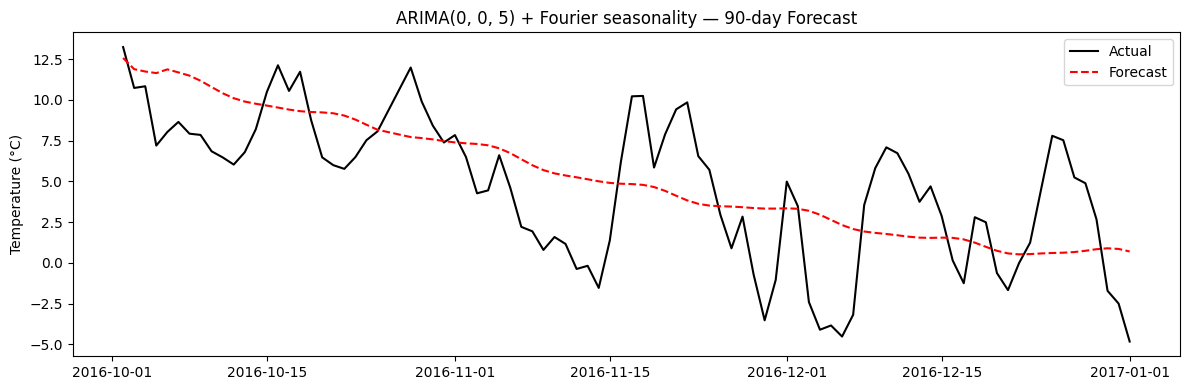

RMSE: 3.65 | MAE: 3.12 | AIC: 12741.76
🏃 View run arima-manual at: http://localhost:5050/#/experiments/3/runs/4fbe5731468147ad85c7b63d90a99562
🧪 View experiment at: http://localhost:5050/#/experiments/3


In [12]:
order = (0, 0, 5)

mlflow.set_tracking_uri("http://localhost:5050")
mlflow.set_experiment("temperature-forecast-simple")

with mlflow.start_run(run_name="arima-manual"):
    # Fit ARIMA with Fourier exogenous regressors for seasonality
    model = ARIMA(train["temperature"], order=order, exog=exog_train)
    results = model.fit()

    # Forecast on test period
    forecast = results.forecast(steps=len(test), exog=exog_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(test["temperature"], forecast))
    mae = mean_absolute_error(test["temperature"], forecast)

    # Log parameters
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_periods", list(SEASONAL_PERIODS.keys()))
    mlflow.log_param("n_train_days", len(train))
    mlflow.log_param("n_test_days", len(test))

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("aic", results.aic)
    mlflow.log_metric("bic", results.bic)

    # Log forecast plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(test.index, test["temperature"], label="Actual", color="black")
    ax.plot(test.index, forecast, label="Forecast", color="red", linestyle="--")
    ax.set_title(f"ARIMA{order} + Fourier seasonality — 90-day Forecast")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.tight_layout()
    fig.savefig("forecast.png", dpi=100)
    mlflow.log_artifact("forecast.png")
    plt.show()

    # Log model (simple + robust across MLflow versions)
    with tempfile.TemporaryDirectory() as tmp_dir:
        model_dir = os.path.join(tmp_dir, "arima_model")
        mlflow.statsmodels.save_model(results, path=model_dir)
        mlflow.log_artifacts(model_dir, artifact_path="arima_model")

    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | AIC: {results.aic:.2f}")

## Bonus: autolog

With `mlflow.statsmodels.autolog()`, statsmodels parameters and metrics are logged automatically.

In [ ]:
mlflow.statsmodels.autolog()

with mlflow.start_run(run_name="arima-autolog"):
    model = ARIMA(train["temperature"], order=(3, 1, 2), exog=exog_train)
    results = model.fit()
    print(f"AIC: {results.aic:.2f}")

mlflow.statsmodels.autolog(disable=True)

---
**Next:** Open the MLflow UI at http://localhost:5050 and explore the logged runs.